In [23]:
### imports ###
import pygmt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg 

from pygmt.clib import Session
from pygmt.helpers import GMTTempFile


%matplotlib inline
%matplotlib widget

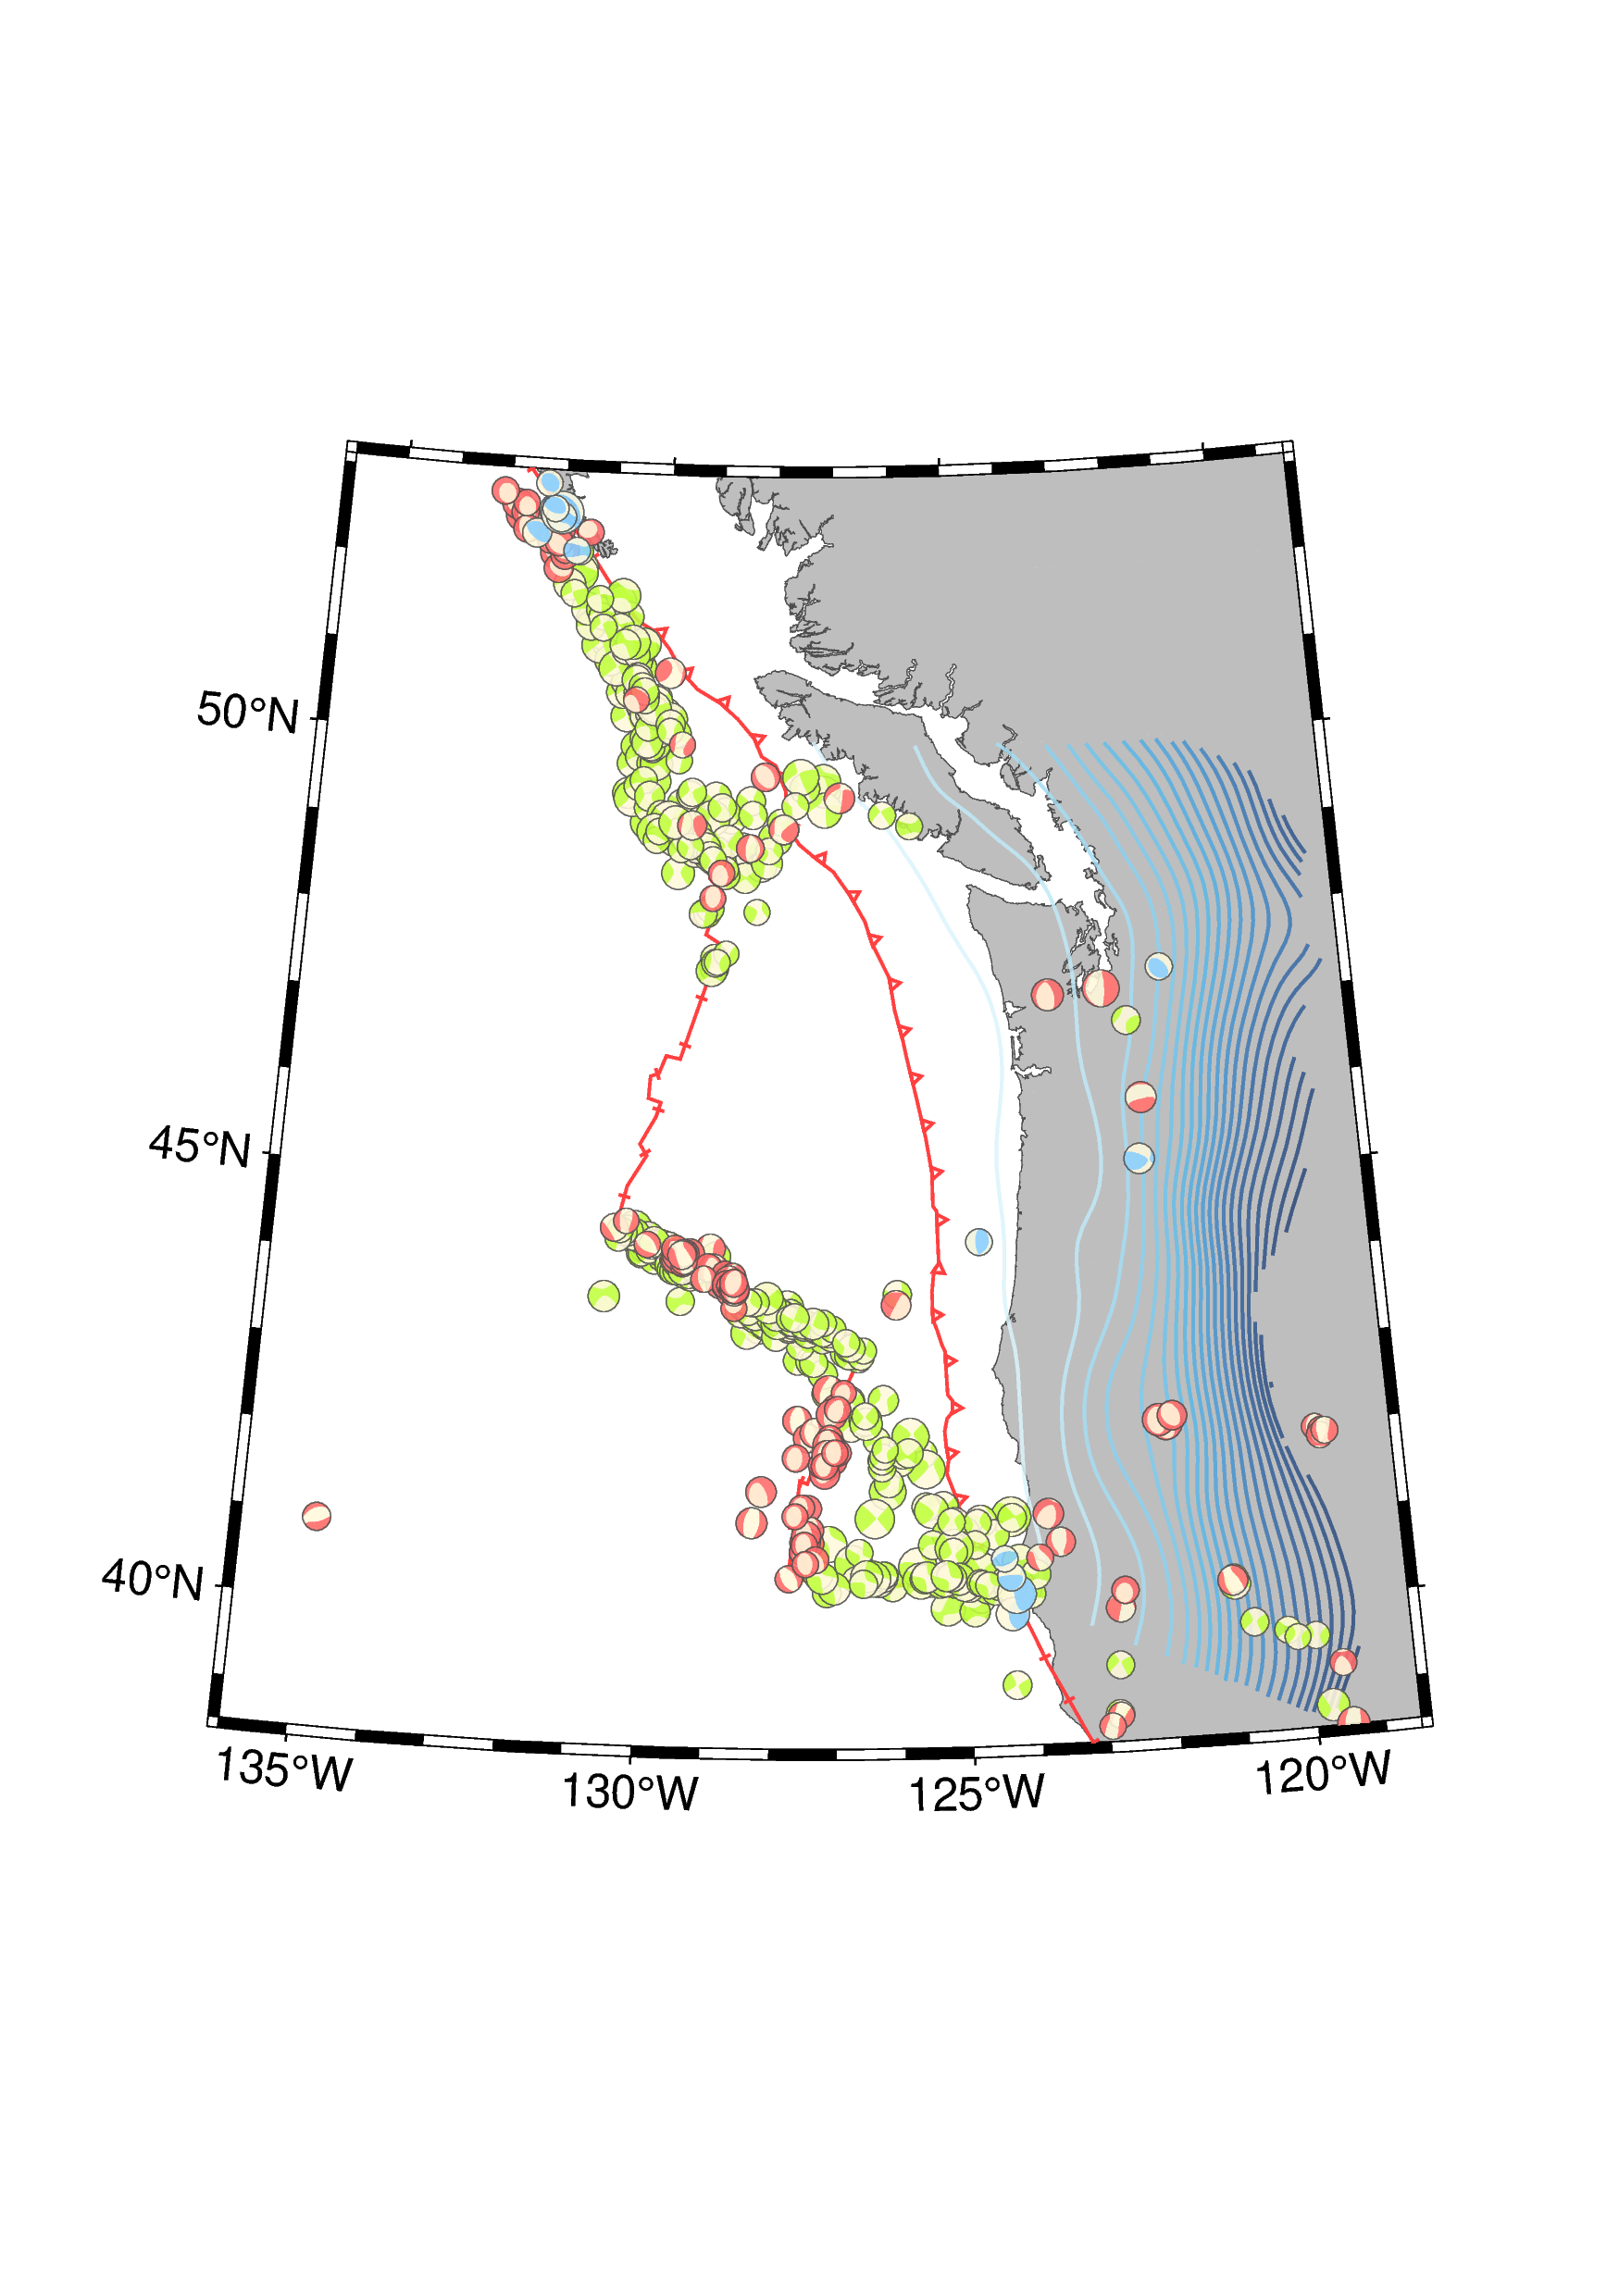

In [44]:
### GMT basemap ###

fig = pygmt.Figure()

# figure config
pygmt.config(MAP_FRAME_TYPE="fancy", FONT="Helvetica",\
             FONT_ANNOT_PRIMARY ="12p", FONT_LABEL = "11p")

fig.coast(region=[0, 14.8, 0, 21], projection="Q14.8c", frame=False, land="white")
# this should be A5
# Equidistant Cylindrical Projection (Plate Carrée)
# https://www.pygmt.org/latest/projections/cyl/cyl_equidistant.html

fig.shift_origin(xshift="2c", yshift="5c") # does NOT include border width

fig.coast(region=[-136, -118.5, 38.5, 53.1],\
        projection="B-127.25/45.8/43.19/47.86/11c",\
        water="white", land="grey", shorelines="0.2,grey30",\
        frame=["WeSn", "fa"], resolution="h", area_thresh="1000")


# grid = pygmt.datasets.load_earth_relief("03m", registration="gridline", region=[-136, -118.5, 38.5, 53.1])
# fig.grdimage(grid=grid, cmap="bin/seabluelandgrey.cpt", transparency=45)
#######################

## plotting slab 2.0 
# Hayes et al. (2018)
pygmt.makecpt(output="bin/abyss_slab2.0", series=[-620, 0], cmap="bin/abyss.cpt")
fig.plot(data="bin/cas_slab2_dep_02.24.18_contours.in", cmap="bin/abyss_slab2.0",\
         pen=f"0.85p", transparency=15) # Hindu Kush, bounding coords 66 74 40 34

## plotting bird plates
fig.plot(data="bin/bird_plates.xy", pen=f"0.8p,brown1", style="f")


## plotting Harvard CMT earthquakes
# https://www.globalcmt.org/
fig.meca(
    spec="bin/cascadiastrikeslip_dropname.xy",
    convention="mt", scale="0.25",
    compressionfill="olivedrab1",
    extensionfill="cornsilk",
    pen="thinnest,gray30,solid",
    transparency=12
)
fig.meca(
    spec="bin/cascadianormal_dropname.xy",
    convention="mt", scale="0.25",
    compressionfill="indianred1",
    extensionfill="cornsilk",
    pen="thinnest,gray30,solid",
    transparency=12
)
fig.meca(
    spec="bin/cascadiasubduction_dropname.xy",
    convention="mt", scale="0.25",
    compressionfill="skyblue1",
    extensionfill="cornsilk",
    pen="thinnest,gray30,solid",
    transparency=12
)


fig.show()
fig.savefig("cascadia.png")

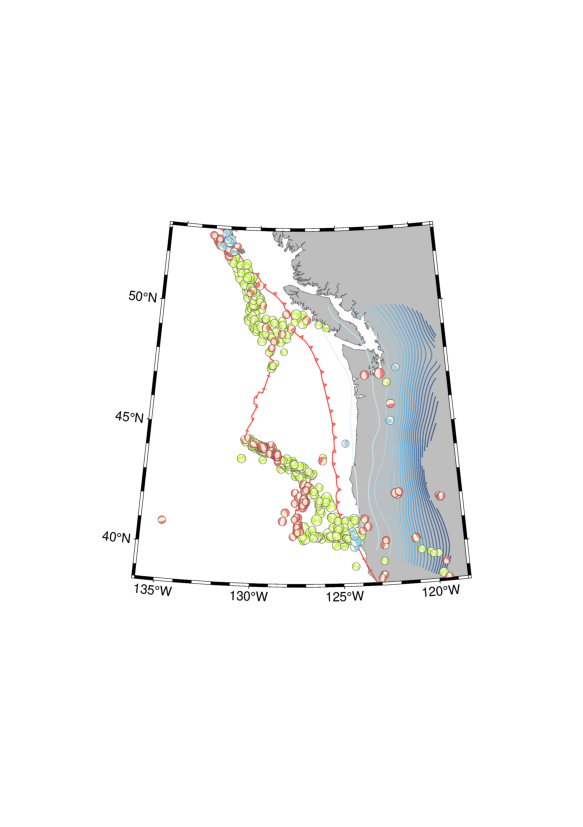

In [48]:
def interactive_pygmt_test(png_path, region, projection, xshift, yshift):
    '''
    Creates an interactive map from a borderless pyGMT png where you can click to retrieve coordinates.

    Parameters:
        png_path (str): path to the borderless pyGMT map

    '''

    ########## inputs ##########
    # turn pygmt region input into gmt str
    region_str = f"{region[0]}/{region[1]}/{region[2]}/{region[3]}"


    # unpact xshift yshift
    def unpack_xyshift(str):
      if str[-1].isalpha():
        shift_value = str[:-1]
        shift_unit = str[-1]

      return float(shift_value), shift_unit


    xshift_value, xshift_unit = unpack_xyshift(xshift)
    yshift_value, yshift_unit = unpack_xyshift(yshift)

    # we are working in cm
    if xshift_unit == "c":
      xshift_value = xshift_value
    elif xshift_unit == "i":
      xshift_value = xshift_value * 2.54
    elif xshift_unit == "p":
      xshift_value = (xshift_value * 72) * 2.54
    else:
      raise Exception("invalid xshift input (must be either c, i or p)") 
      
    # similarly for y
    if yshift_unit == "c":
      yshift_value = yshift_value
    elif yshift_unit == "i":
      yshift_value = yshift_value * 2.54
    elif yshift_unit == "p":
      yshift_value = (yshift_value * 72) * 2.54
    else:
      raise Exception("invalid yshift input (must be either c, i or p)") 
    
    # determine image dimension
    img = Image.open(png_path)
    width, height = img.size # canvas (width,height) tuple in pixels
    DPI_horz, DPI_vert = img.info.get('dpi')

    assert DPI_horz == DPI_vert # is this != even possible??


    ################################################
    ########## plots ##########
    fig = plt.figure(figsize=(width/DPI_horz, height/DPI_vert))
    ax1 = plt.subplot(111)

    '''
    code above doesnt "work' in the sense that its unnecessary
    as figure size != subplot axis size --> what to do with multiple subplots eg timeseries
    edit: subplot axis is currently set to image pixel size so ok now
    '''

    # plotting pygmt png image in bottom layer
    img = mpimg.imread(png_path)

    plt.imshow(img, origin='upper')
    # SOMEHOW MATPLOTLIB MIRRORS MY IMAGE WHEN I SET (0,0) AS BOTTOM LEFT (origin='lower')
    # i fix this later directly at pos_to_lonlat (by reversing input limit)

    
    def pos_to_lonlat(x, y, xshift_value, yshift_value):
      # xyshift input in inches
      x=(x/DPI_horz) * 2.54 # convert pixel to cm
      x = x - xshift_value

      y=(y/DPI_vert) * 2.54 # cm
      height_cm = (height/DPI_vert) * 2.54
      y = height_cm - y - yshift_value
      
      x=[x] # must be list w one value or np array
      y=[y]
      
      ### lon lat conversion using mapproject ###
      with Session() as ses:
        # with ses.virtualfile_in(data=data) as fin:
        with ses.virtualfile_from_vectors(x, y) as fin:
          args = [f'{fin}', f'-R{region_str}', f'-J{projection}', '-I'] # -V
          with GMTTempFile() as fout:
            ses.call_module(module="mapproject", args=' '.join(args)+ " ->" + fout.name)
            out = fout.read().strip()

      lon, lat = [float(i) for i in out.split(' ')]
    
      return lon, lat


    pos = [] # in format [[None, None], [x, y], [x, y], ...]
    lonlat = []

    def onclick(event):
      pos.append([event.xdata, event.ydata])

      lon, lat = pos_to_lonlat(pos[-1][0], pos[-1][1],\
                               xshift_value, yshift_value)
      # pos[-1] represents last click (list with x, y)
      # this is x y input in pixels --> need to convert to in inches (gmt input)
      lonlat.append([lon, lat]) # converts x y to lon lat and appends

      ax1.set_title(f'Click {len(pos)}: {lon}, {lat}')

    
    cid=fig.canvas.mpl_connect('button_press_event', onclick)

    plt.axis('off')
    plt.show()

    return

region=[-136, -118.5, 38.5, 53.1]
projection="B-127.25/45.8/43.19/47.86/11c"

%matplotlib widget
interactive_pygmt_test("cascadia.png", region, projection, "2c", "5c")